# Audio Signal Classification using Long Short-Term Memory (LSTM) in TensorFlow

## Introduction

### What is LSTM?
Long Short-Term Memory (LSTM) networks are a type of Recurrent Neural Network (RNN) capable of learning long-term dependencies. They were introduced by Hochreiter and Schmidhuber in 1997 and were refined and popularized by many people in subsequent work. LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods is practically their default behavior, not something they struggle to learn.

LSTM networks are well-suited to classify, process, and predict time series given time lags of unknown size and duration between important events. They work exceptionally well on a large variety of problems and are now widely used.

### How does LSTM work?
LSTM networks consist of a chain-like structure with four neural network layers interacting in a very special way. Instead of having a single neural network layer, there are four, which are interacting in a very specific manner. This complex structure allows LSTMs to store and retrieve data over long periods, which is crucial for time series data and sequence tasks such as audio signal classification.

### Application in Audio Signal Classification
In this notebook, we will demonstrate audio signal classification using LSTM networks with TensorFlow. We will use the `crema_d` dataset from TensorFlow Datasets, which contains labeled audio clips of people speaking with different emotions. We will preprocess the audio data, extract features using Mel-frequency cepstral coefficients (MFCCs), and build an LSTM model to classify the emotions in the audio clips.

## Step 1: Setup

First, let's install and import the necessary libraries.



In [15]:
# Install required libraries
!pip install tensorflow tensorflow-datasets librosa

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import numpy as np
import librosa
import os

# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)



import matplotlib.pyplot as plt
Step 2: Load and Preprocess the Dataset
We will use the CIFAR-10 dataset, which consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class.

In [17]:
!pip install pydub

In [21]:
# Load the CREMA-D dataset
dataset, info = tfds.load('crema_d', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

# Function to extract features from audio signals
def extract_features(audio, sample_rate=16000):
    audio = audio.astype(np.float32)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled = np.mean(mfccs.T, axis=0)
    return mfccs_scaled

# Extract features and labels from the dataset
def preprocess_dataset(dataset):
    features = []
    labels = []
    for audio, label in tfds.as_numpy(dataset):
        audio = audio.flatten()
        mfccs = extract_features(audio)
        features.append(mfccs)
        labels.append(label)
    return np.array(features), np.array(labels)

# Preprocess the train and test datasets
X_train, y_train = preprocess_dataset(train_dataset)
X_test, y_test = preprocess_dataset(test_dataset)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)



Step 3: Data Augmentation
To improve the generalization of our model, we will use data augmentation.

In [22]:
# Reshape the data to fit the LSTM input requirements
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(info.features['label'].names), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 40, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,470 (212.77 KB)

 Trainable params: 54,470 (212.77 KB)

 Non-trainable params: 0 (0.00 B)

Step 4: Build the Model
We will use MobileNetV2 as the base model and add a few layers on top for our specific classification task.

In [23]:
# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))



Epoch 1/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.1694 - loss: 1.7950 - val_accuracy: 0.2362 - val_loss: 1.7249
Epoch 2/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2427 - loss: 1.7148 - val_accuracy: 0.3081 - val_loss: 1.6212
Epoch 3/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2711 - loss: 1.6769 - val_accuracy: 0.3120 - val_loss: 1.6061
Epoch 4/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2771 - loss: 1.6484 - val_accuracy: 0.3188 - val_loss: 1.5968
Epoch 5/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2976 - loss: 1.6160 - val_accuracy: 0.3246 - val_loss: 1.5881
Epoch 6/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3128 - loss: 1.6067 - val_accuracy: 0.3333 - val_loss: 1.5767
Epoch 7/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3181 - loss: 1.5901 - val_accuracy: 0.3256 - val_loss: 1.5722
Epoch 8/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3222 - loss: 1.5812 - val_accuracy: 0

Step 5: Compile and Train the Model
We will compile the model with an appropriate loss function, optimizer, and metrics, and then train it.



49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3840 - loss: 1.4576
Test accuracy: 0.4010


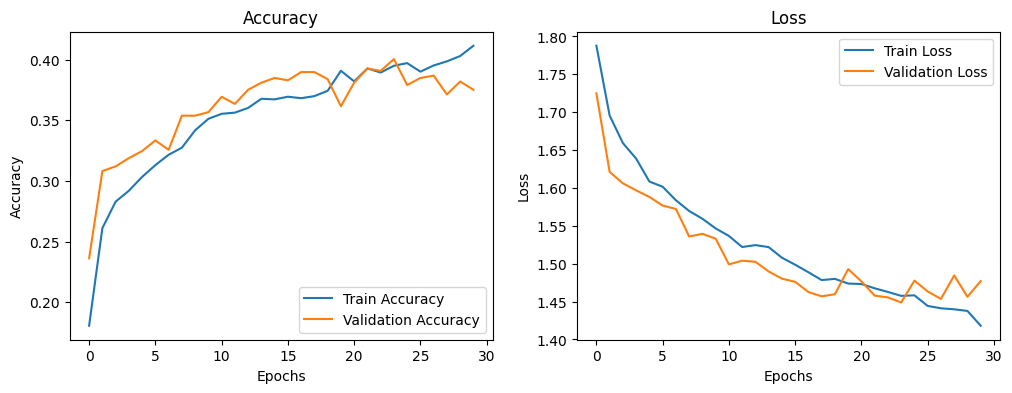

In [24]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy:.4f}')

# Plot the training and validation accuracy and loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

